# Author: Tim Harmling and Alexej Kravtschenko
- **Note:** This notebook was written by the combined effort of Tim Harmling and Alexej Kravtschenko 
- **Description:** With this notebook you can train your own handwriting model form scratch or use an existing model for transfer learning

## Imports

In [1]:
# Unsere Klassen
import handwriting.load_data as load_data
import handwriting.models as models # Use: build_model9v3(img_width, img_height, char) 
import utils.configs as cfg
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import time
import os
import re

## Config

In [2]:
config_path = "../utils/configs.json"
config = cfg.Config(config_path)

# Model Parameter
MODEL_SAVE = bool(config.get_model_parameter()["save"])
MODEL_NAME = config.get_model_parameter()["name"]
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

# Directory Parameter
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["model_dir"])
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["test_dir"])
DATA_BASE_PATH = config.get_directory_parameter()["data_base_path"]

# Training Parameter
SAVE_HISTORY = bool(config.get_training_parameter()["save_history"])
EPOCHS = config.get_training_parameter()["epochs"]
BATCH_SIZE = config.get_training_parameter()["batch_size"] # default: Between 32 - 48
TF_SEED = config.get_training_parameter()["tf_seed"] # default: 42
LEARNING_RATE = config.get_training_parameter()["learning_rate"]
PATIENCE = config.get_training_parameter()["patience"] # default: 10

## Load Data

In [3]:
# Default: seed = 42
# np.random.seed(TF_SEED)
# tf.random.set_seed(TF_SEED)

# Random
#seed = random.randint(1, 1000)
#np.random.seed(seed)
#tf.random.set_seed(seed)

print(LEARNING_RATE)
print(TF_SEED)

0.001
42


In [4]:
load_data.print_samples(DATA_BASE_PATH)
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [5]:
data_to_save = (load_data.max_len, load_data.characters)
import pickle
with open('number.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [6]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['./data\\lines\\m06\\m06-106\\m06-106-03.png', './data\\lines\\a01\\a01-132u\\a01-132u-03.png'] ['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell']
Validation path: ['./data\\lines\\b04\\b04-034\\b04-034-04.png', './data\\lines\\a05\\a05-004\\a05-004-05.png'] ['Newmarket|urban|council|,|says|:|"|I|shall|always|feel|this|as|a', 'and|operations|.|This|would|apply|also|in|the']
Testing path: ['./data\\lines\\a02\\a02-093\\a02-093-01.png', './data\\lines\\n02\\n02-049\\n02-049-03.png'] ['priority|to|the|clash|over|Northern|Rhodesia|on|his', 'look|as|though|it|was|only|what|you|expected|of|me|,']


## Create Dataset

In [7]:
# Has to be here because load data functions need to be called before
import handwriting.tokenizer as tokenizer
import handwriting.custom_image_generator as cgi

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)

#train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

## Show Examples

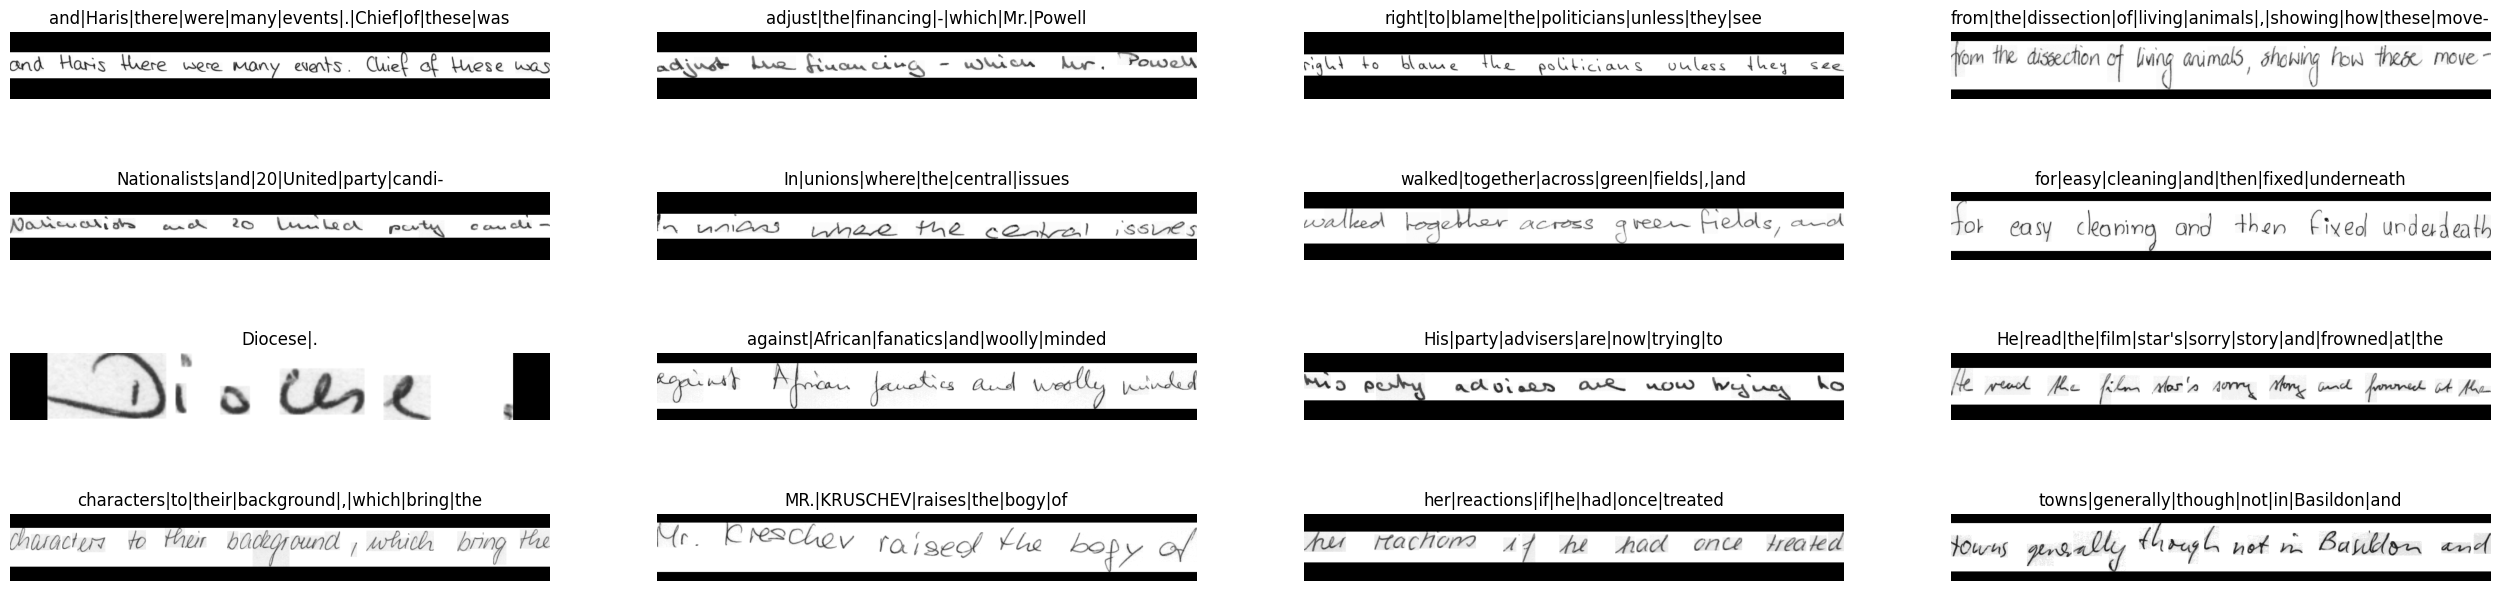

In [8]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

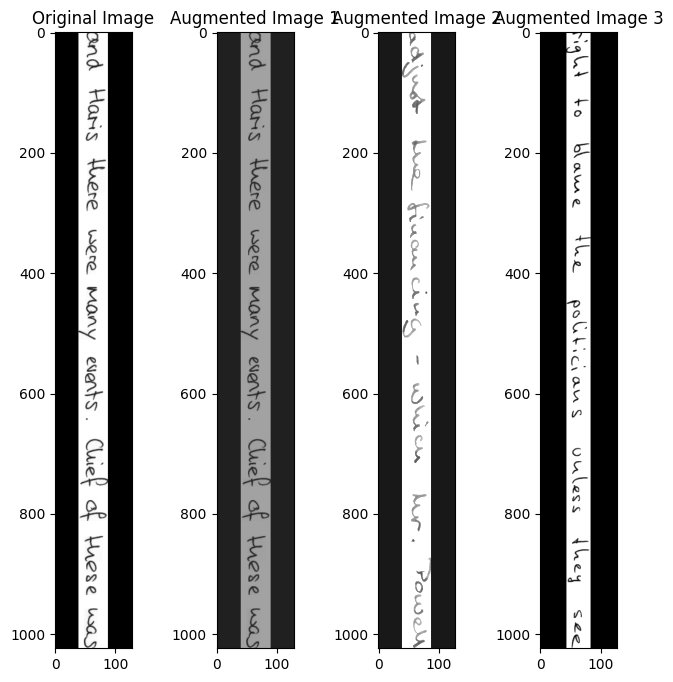

In [9]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=TF_SEED),
        tf.keras.layers.RandomContrast(0.5,seed=TF_SEED)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

# Train Keras Model

In [10]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    """Loads model weights if they exist.

    This function checks if the model weights exist and loads them into the model.

    Args:
        model: The Keras model.

    Returns:
        None
    """
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [11]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    #model_load_weights_if_exists(model) # Uncomment this line for transfer learning
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE * 0.2, min_lr=1e-6, verbose=1)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[reduce_lr, early_stopping])    
    return prediction_model, history

In [12]:
char = len(tokenizer.char_to_num.get_vocabulary())
model = models.build_model9v3(IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 1024, 128,   0           []                               
                                1)]                                                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 1024, 128, 4  480         ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 Conv2 (Conv2D)                 (None, 1024, 128, 9  41568       ['Conv1[0][0]']                  
                                6)                                           

In [ ]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/5


# Plot helper functions


In [ ]:
def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.
    
    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [ ]:
# Creates a directory if it doesn't exist
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

In [ ]:
def create_new_plot_name(model_name, names, format):
    
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    
    return format.replace(model_name,new_model_name)

# Model Testing

In [ ]:
""" Author: Alexej Kravtschenko (main) and Tim Harmling (wrote)
    
Creates a new plot name based on existing names.
This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
     
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [ ]:
# Saves the model after training if MODEL_SAVE = True
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)